In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/aandreassen/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aandreassen/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aandreassen/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aandreassen/.local/lib/python3.5/site-packag

In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22) 
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('legend', fontsize=15)

# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

## Process data

In [6]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

In [7]:
dataset = np.load(data_dir + '1D_aLund_train.npz')

In [8]:
X = dataset['X']
Y = dataset['Y']

In [9]:
X = preprocess_data(X)
Y = to_categorical(Y, num_classes=2)

In [10]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1, shuffle=True)

In [11]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(1620000, 51, 7)
(1620000, 2)
(180000, 51, 7)
(180000, 2)


# Build Model

In [12]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

# Train model

In [13]:
save_label = 'DCTR_ee_dijets_1D_aLund'

checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='min')

CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [checkpoint, CSVLogger, EarlyStopping]

In [14]:
history = dctr.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 1000,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)

Train on 1620000 samples, validate on 180000 samples
Epoch 1/100
1620000/1620000 [==============================] - 20s 12us/step - loss: 0.7014 - acc: 0.5010 - val_loss: 0.6940 - val_acc: 0.4992

Epoch 00001: val_loss improved from inf to 0.69400, saving model to ./saved_models/DCTR_ee_dijets_1D_aLund.h5
Epoch 2/100
1620000/1620000 [==============================] - 18s 11us/step - loss: 0.6936 - acc: 0.5032 - val_loss: 0.6932 - val_acc: 0.5054

Epoch 00002: val_loss improved from 0.69400 to 0.69318, saving model to ./saved_models/DCTR_ee_dijets_1D_aLund.h5
Epoch 3/100
1620000/1620000 [==============================] - 17s 11us/step - loss: 0.6934 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.5030

Epoch 00003: val_loss did not improve from 0.69318
Epoch 4/100
1620000/1620000 [==============================] - 18s 11us/step - loss: 0.6931 - acc: 0.5057 - val_loss: 0.6932 - val_acc: 0.5024

Epoch 00004: val_loss improved from 0.69318 to 0.69317, saving model to ./saved_models/DCTR_ee_d

# Plot History

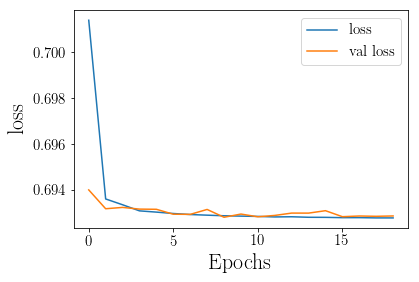

In [15]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

# Load Model

In [16]:
# load model from saved file
#dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_aLund.h5')

# Validation

## Load Datasets

In [17]:
test_dataset_0 = np.load(data_dir+'test1D_default.npz')
test_dataset_1 = np.load(data_dir+'test1D_aLund.npz')

In [18]:
# Define labels for legends
label_0 = r'aLund=0.68'

label_1 = r'aLund=0.80'

pythia_text = r'\textsc{Pythia 8}' + '\n' + r'$e^+e^- \to Z \to $ dijets' +'\n'+ r"anti-$k_{\mathrm{T}}$, $R=0.8$"
def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg.set_title(pythia_text, prop={'size':14})
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get predictions

In [19]:
# Load test datasets
X0_test = preprocess_data(test_dataset_0['jet'])
X1_test = preprocess_data(test_dataset_1['jet'])

In [20]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_test, batch_size=1000)
preds_1 = dctr.predict(X1_test, batch_size=1000)

## Get weights

In [21]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

## Analyze weights

In [22]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

1.2439463
1.1490545
1.3519024
1.1482241


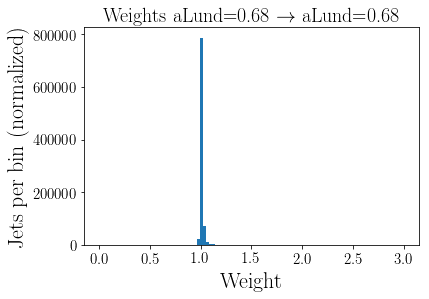

In [23]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_0, fontsize=20)
plt.show()

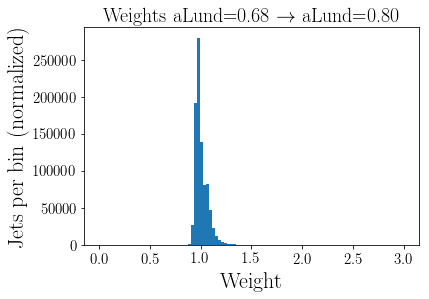

In [24]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_1, fontsize=20)
plt.show()

# Validation Plots

In [25]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

## Multiplicity

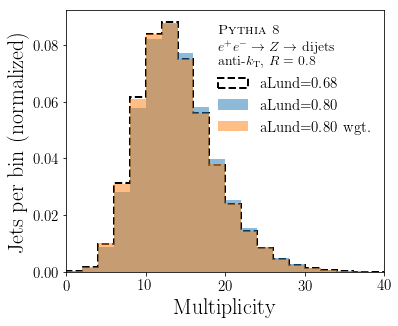

In [26]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,40,21)
hist0 = plt.hist(test_dataset_0['multiplicity'], bins = bins, label = label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['multiplicity'], bins = bins, label = label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['multiplicity'], bins = bins, label = label_1 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('Multiplicity')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([0,40])
make_legend()
plt.show()

## Nsubjettiness

### tau21

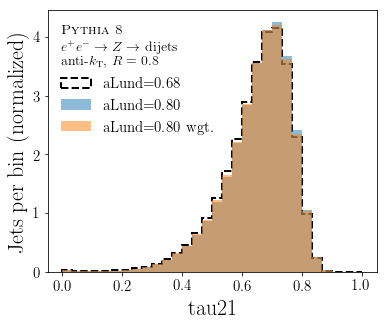

In [27]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau21'], bins=bins, label=label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['tau21'], bins=bins, label=label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['tau21'], bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('tau21')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

### tau32

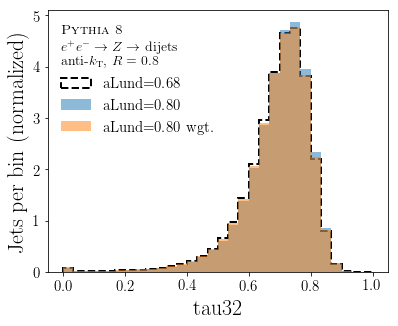

In [28]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau32'], bins=bins, label=label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['tau32'], bins=bins, label=label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['tau32'], bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('tau32')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

## ECF

### N=3, $\beta$=4

/home/aandreassen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aandreassen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/aandreassen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


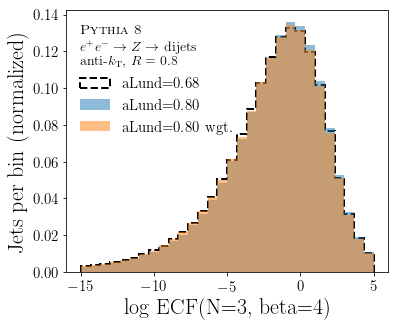

In [29]:
plt.figure(figsize=(6,5))
bins = np.linspace(-15,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N3_B4']), bins=bins, label=label_0, **plot_style_0)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N3_B4']), bins=bins, label=label_1, **plot_style_1)
hist3 = plt.hist(np.log(test_dataset_1['ECF_N3_B4']), bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('log ECF(N=3, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

### N=4, $\beta$=4

/home/aandreassen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aandreassen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/aandreassen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


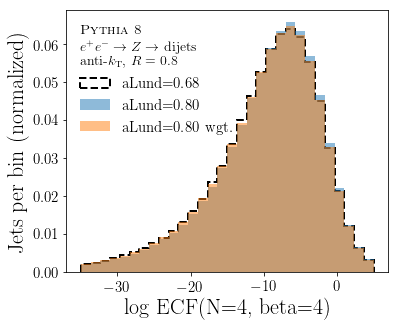

In [30]:
plt.figure(figsize=(6,5))
bins = np.linspace(-35,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N4_B4']), bins=bins, label=label_0, **plot_style_0)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N4_B4']), bins=bins, label=label_1, **plot_style_1)
hist3 = plt.hist(np.log(test_dataset_1['ECF_N4_B4']), bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('log ECF(N=4, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

## Kaons

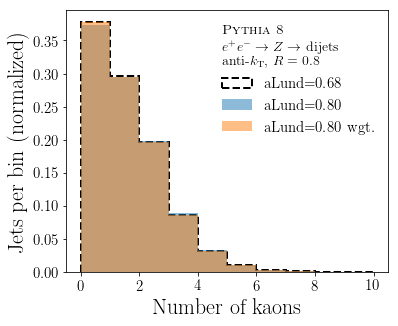

In [31]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,10,11)
hist0 = plt.hist(test_dataset_0['number_of_kaons'], bins=bins, label=label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['number_of_kaons'], bins=bins, label=label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['number_of_kaons'], bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('Number of kaons')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

# Fitting

## Loss Curve Model

In [32]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, n_MC_params, default_MC_params, trainable_MC_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_MC_params = n_MC_params
        self.MC_params = default_MC_params
        self.trainable_MC_params = trainable_MC_params

    
    def build(self, input_shape):
        # Convert input MC parameters to weights and make then trainable or non-trainable
        for i in range(self.n_MC_params):
            self.MC_params[i] = self.add_weight(name='MC_param_{}'.format(i), 
                                                shape=(1, 1),
                                                initializer=keras.initializers.Constant(self.MC_params[i]),
                                                trainable=self.trainable_MC_params[i])
            
        self.MC_params = keras.backend.tf.concat(self.MC_params, axis = -1)
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        # Add MC params to each input particle (but not to the padded rows)
        concat_input_and_params = keras.backend.tf.where(keras.backend.abs(input[...,0])>0,
                                                         self.MC_params*keras.backend.ones_like(input[...,0:self.n_MC_params]),
                                                         keras.backend.zeros_like(input[...,0:self.n_MC_params]))
        return keras.backend.concatenate([input, concat_input_and_params], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+self.n_MC_params)

In [33]:
def get_DCTR_fit_model(DCTR_model, 
                       X_dim, 
                       n_MC_params, 
                       default_MC_params,
                       trainable_MC_params):
    """ 
    Get a DCTR model that trains on the input MC parameters
    
    Arguments:
    - DCTR_model : a PFN model that has been trained on a to continuously interpolate over the input MC dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - DCTR_fit_model: a compiled model that gradient descends only on the trainable MC parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_MC_params, "X_dim must be larger than n_MC_params. X_dim includes the dimensionality of the 4-vector + number of MC parameters"
    assert n_MC_params == len(default_MC_params), "Dimension mismatch between n_MC_params and number of default MC parameters given. len(default_MC_params) must equal n_MC_params"
    assert n_MC_params == len(trainable_MC_params), "Dimension mismatch between n_MC_params and trainable_MC_params. len(trainable_MC_params) must equal n_MC_params."
    assert np.any(trainable_MC_params), "All parameters are set to non-trainable."
    
    # Define input to DCTR_fit_model
    non_param_input = keras.layers.Input((None, X_dim - n_MC_params))

    # Construct layer that adds trainable and non-trainable parameters to the input
    add_params_layer = AddParams2Input(n_MC_params, default_MC_params, trainable_MC_params)
    time_dist     = keras.layers.TimeDistributed(add_params_layer, name='tdist')(non_param_input)     

    # Set all weights in DCTR_model to non-trainable
    for layer in DCTR_model.model.layers:
        layer.trainable = False
        
    # get the graph and the weights from the DCTR_model
    output = DCTR_model.model(inputs = time_dist)

    # Define full model
    DCTR_fit_model = fitmodel = keras.models.Model(inputs = non_param_input, outputs = output)
    
    optimizer = keras.optimizers.Adam(lr=1e-4)
    
    # Compile with loss function
    DCTR_fit_model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    
    return DCTR_fit_model

In [34]:
dctr_fit_model = get_DCTR_fit_model(dctr, 
                       X_dim =7, 
                       n_MC_params = 3, 
                       default_MC_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                       trainable_MC_params = [False, True, False]) # Only train aLund

dctr_fit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
tdist (TimeDistributed)      (None, None, 7)           3         
_________________________________________________________________
model_1 (Model)              (None, 2)                 57130     
Total params: 57,133
Trainable params: 1
Non-trainable params: 57,132
_________________________________________________________________


In [35]:
def set_MC_params(dctr_fit_model, MC_params):
    alphaS, aLund, StoUD = MC_params
    weights = [np.array([[alphaS]],   dtype=np.float32),
               np.array([[aLund]],    dtype=np.float32),
               np.array([[StoUD]], dtype=np.float32)]
    dctr_fit_model.layers[1].set_weights(weights)

In [36]:
dctr_fit_model.layers[1].get_weights()

[array([[0.68]], dtype=float32),
 array([[0.1365]], dtype=float32),
 array([[0.217]], dtype=float32)]

## Load Data

In [37]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_aLund.npz')

In [38]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [39]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [40]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

## Evaluate Loss as a function of MC parameter

In [41]:
def get_loss(X, Y, dctr_fit_model, MC_params, batch_size = 1000):
    set_MC_params(dctr_fit_model, MC_params)
    return dctr_fit_model.evaluate(x=X, y = Y, batch_size=batch_size)

In [42]:
dctr_fit_model.layers[1].get_weights()

[array([[0.68]], dtype=float32),
 array([[0.1365]], dtype=float32),
 array([[0.217]], dtype=float32)]

In [43]:
aLund_loss = np.array([(aLund, get_loss(X_fit, Y_fit, dctr_fit_model, [aLund, 0.1365, 0.217])) for aLund in np.linspace(0.6,0.9, 31)])

1800000/1800000 [==============================] - 7s 4us/step


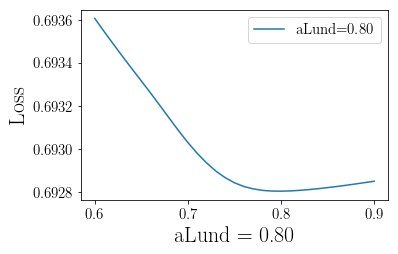

In [44]:
plt.plot(*aLund_loss.T, label = label_1)
plt.ylabel('Loss')
plt.xlabel(r'aLund = 0.80')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
def get_min_loss(losses, x0):
    f = sp.interpolate.interp1d(losses[:,0], losses[:,1], fill_value="extrapolate")
    return sp.optimize.minimize(f, x0=x0)['x']

get_min_loss(aLund_loss, x0=0.68)

array([0.79999999])

## Tune with Gradient Descent

In [46]:
dctr_fit_model.layers[1].get_weights()

[array([[0.9]], dtype=float32),
 array([[0.1365]], dtype=float32),
 array([[0.217]], dtype=float32)]

In [47]:
set_MC_params(dctr_fit_model, [0.68, 0.1365, 0.217])

In [48]:
print_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: print("aLund fit = ", 
                                               dctr_fit_model.get_weights()[0][0][0]))
fit_vals = [0.68]
append_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(dctr_fit_model.get_weights()[0][0][0]))

callbacks = [print_weights, append_weights]

In [49]:
dctr_fit_model.fit(X_fit, Y_fit,
                   epochs=40, 
                   batch_size=10000,
                   callbacks = callbacks)

Epoch 1/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6931
aLund fit =  0.6959674
Epoch 2/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6930
aLund fit =  0.7107291
Epoch 3/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6929
aLund fit =  0.72412413
Epoch 4/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6929
aLund fit =  0.73554707
Epoch 5/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6929
aLund fit =  0.7451192
Epoch 6/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6928
aLund fit =  0.75290346
Epoch 7/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6928
aLund fit =  0.7596639
Epoch 8/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6928
aLund fit =  0.7652607
Epoch 9/40
1800000/1800000 [==============================] - 9s 5us/step - loss: 0.6928
aLund fit = 

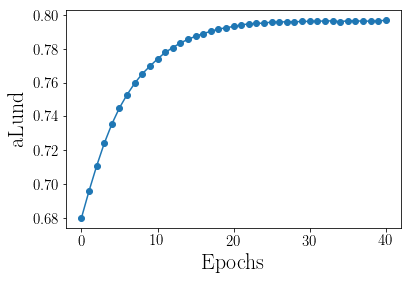

In [50]:
plt.plot(fit_vals, marker='o')
plt.xlabel("Epochs")
plt.ylabel(r'aLund')
plt.show()